<a href="https://colab.research.google.com/github/mohameddhameem/TensorflowCertification/blob/main/AdvancedCNN/Course_2_Part_6_Lesson_3_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [8]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
  
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
  
pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

--2021-04-17 05:54:57--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 142.250.107.128, 173.194.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   153MB/s    in 0.5s    

2021-04-17 05:54:58 (153 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 150, 150, 3) 0                

In [4]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])


In [5]:
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

local_zip = '//tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

# Define our example directories and files
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')


train_cats_dir = os.path.join(train_dir, 'cats') # Directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # Directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') # Directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')# Directory with our validation dog pictures

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

--2021-04-17 05:47:48--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.197.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  78.5MB/s    in 0.8s    

2021-04-17 05:47:49 (78.5 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [6]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20
100/100 - 53s - loss: 0.3235 - accuracy: 0.8730 - val_loss: 0.1807 - val_accuracy: 0.9390
Epoch 2/20
100/100 - 17s - loss: 0.2274 - accuracy: 0.9160 - val_loss: 0.2001 - val_accuracy: 0.9280
Epoch 3/20
100/100 - 17s - loss: 0.2050 - accuracy: 0.9180 - val_loss: 0.1384 - val_accuracy: 0.9520
Epoch 4/20
100/100 - 17s - loss: 0.2022 - accuracy: 0.9340 - val_loss: 0.1032 - val_accuracy: 0.9610
Epoch 5/20
100/100 - 17s - loss: 0.1835 - accuracy: 0.9400 - val_loss: 0.1127 - val_accuracy: 0.9620
Epoch 6/20
100/100 - 17s - loss: 0.1805 - accuracy: 0.9375 - val_loss: 0.1551 - val_accuracy: 0.9500
Epoch 7/20
100/100 - 17s - loss: 0.1574 - accuracy: 0.9430 - val_loss: 0.1573 - val_accuracy: 0.9500
Epoch 8/20
100/100 - 18s - loss: 0.1941 - accuracy: 0.9360 - val_loss: 0.1131 - val_accuracy: 0.9630
Epoch 9/20
100/100 - 17s - loss: 0.1534 - accuracy: 0.9415 - val_loss: 0.1754 - val_accuracy: 0.9520
Epoch 10/20
100/100 - 17s - loss: 0.1521 - accuracy: 0.9455 - val_loss: 0.1919 - val_accura

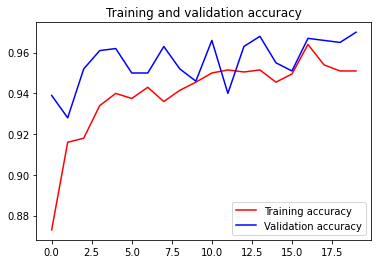

<Figure size 432x288 with 0 Axes>

In [7]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

# Using Pre Trained model

In [10]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
base_model = InceptionV3(weights='imagenet',
                         input_shape=(150,150,3),
                         include_top=False)
for layer in base_model.layers:
  layer.trainable = False
  
base_model.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_376 (Conv2D)             (None, 74, 74, 32)   864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_376 (BatchN (None, 74, 74, 32)   96          conv2d_376[0][0]                 
__________________________________________________________________________________________________
activation_376 (Activation)     (None, 74, 74, 32)   0           batch_normalization_376[0][0]    
______________________

In [11]:
last_layer = base_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [18]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( base_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_376 (Conv2D)             (None, 74, 74, 32)   864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_376 (BatchN (None, 74, 74, 32)   96          conv2d_376[0][0]                 
__________________________________________________________________________________________________
activation_376 (Activation)     (None, 74, 74, 32)   0           batch_normalization_376[0][0]    
____________________________________________________________________________________________

In [14]:
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

local_zip = '//tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

# Define our example directories and files
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')


train_cats_dir = os.path.join(train_dir, 'cats') # Directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # Directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') # Directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')# Directory with our validation dog pictures

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

--2021-04-17 06:54:12--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 142.250.99.128, 74.125.199.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   127MB/s    in 0.5s    

2021-04-17 06:54:12 (127 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [15]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20
100/100 - 21s - loss: 0.3622 - accuracy: 0.8625 - val_loss: 0.1055 - val_accuracy: 0.9570
Epoch 2/20
100/100 - 17s - loss: 0.1955 - accuracy: 0.9240 - val_loss: 0.1453 - val_accuracy: 0.9500
Epoch 3/20
100/100 - 17s - loss: 0.2000 - accuracy: 0.9290 - val_loss: 0.1420 - val_accuracy: 0.9510
Epoch 4/20
100/100 - 17s - loss: 0.2148 - accuracy: 0.9130 - val_loss: 0.1165 - val_accuracy: 0.9620
Epoch 5/20
100/100 - 17s - loss: 0.1898 - accuracy: 0.9355 - val_loss: 0.0950 - val_accuracy: 0.9650
Epoch 6/20
100/100 - 17s - loss: 0.1835 - accuracy: 0.9345 - val_loss: 0.1211 - val_accuracy: 0.9610
Epoch 7/20
100/100 - 17s - loss: 0.1717 - accuracy: 0.9380 - val_loss: 0.0898 - val_accuracy: 0.9700
Epoch 8/20
100/100 - 17s - loss: 0.1763 - accuracy: 0.9435 - val_loss: 0.0980 - val_accuracy: 0.9690
Epoch 9/20
100/100 - 17s - loss: 0.1522 - accuracy: 0.9450 - val_loss: 0.1100 - val_accuracy: 0.9670
Epoch 10/20
100/100 - 17s - loss: 0.1735 - accuracy: 0.9420 - val_loss: 0.1175 - val_accura

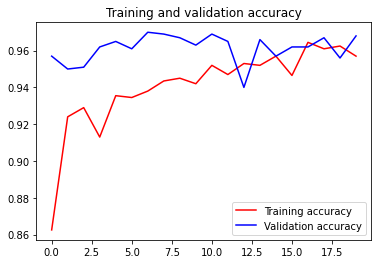

<Figure size 432x288 with 0 Axes>

In [16]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

## Play around with the transfer learning

In [37]:
x = layers.Flatten()(base_model.output) # instead of taking layer 7 lets take the full output
last_layer = base_model.get_layer('mixed10')
last_output = last_layer.output
#x = layers.Flatten()(last_output)
print(x.shape)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( base_model.input, x) 
print(base_model.input)
model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])
model.summary()

(None, 18432)
KerasTensor(type_spec=TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='input_5'), name='input_5', description="created by layer 'input_5'")
Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_376 (Conv2D)             (None, 74, 74, 32)   864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_376 (BatchN (None, 74, 74, 32)   96          conv2d_376[0][0]                 
__________________________________________________________________________________________________
activation_376 (Activat

In [38]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20
100/100 - 22s - loss: 1.1371 - accuracy: 0.8440 - val_loss: 0.8594 - val_accuracy: 0.8700
Epoch 2/20
100/100 - 17s - loss: 0.4216 - accuracy: 0.8875 - val_loss: 0.1975 - val_accuracy: 0.9480
Epoch 3/20
100/100 - 17s - loss: 0.3615 - accuracy: 0.9080 - val_loss: 0.8038 - val_accuracy: 0.8350
Epoch 4/20
100/100 - 17s - loss: 0.4256 - accuracy: 0.8970 - val_loss: 0.2493 - val_accuracy: 0.9380
Epoch 5/20
100/100 - 17s - loss: 0.3144 - accuracy: 0.9160 - val_loss: 0.1729 - val_accuracy: 0.9550
Epoch 6/20
100/100 - 17s - loss: 0.3625 - accuracy: 0.9130 - val_loss: 0.2694 - val_accuracy: 0.9320
Epoch 7/20
100/100 - 17s - loss: 0.3054 - accuracy: 0.9205 - val_loss: 0.1560 - val_accuracy: 0.9650
Epoch 8/20
100/100 - 17s - loss: 0.2763 - accuracy: 0.9280 - val_loss: 0.3099 - val_accuracy: 0.9430
Epoch 9/20
100/100 - 17s - loss: 0.2981 - accuracy: 0.9160 - val_loss: 0.3147 - val_accuracy: 0.9270
Epoch 10/20
100/100 - 17s - loss: 0.2484 - accuracy: 0.9310 - val_loss: 0.1492 - val_accura

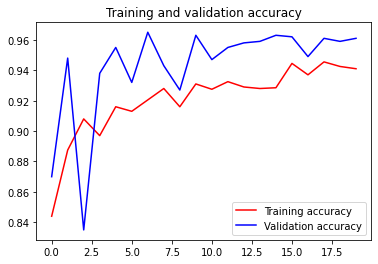

<Figure size 432x288 with 0 Axes>

In [39]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()